# Scheme 1: First Order Approx.

Use first-order Taylor approximation:
$$
\begin{aligned}
\mathbf{q}_{t+1} &= q_t + \dot{q}_t\Delta t + O(\Delta t) \\
&\approx q_t + \frac{\Delta t}{2}q_t \otimes \omega_q  \\
&= q_t + \frac{\Delta t}{2}\mathbf{\Omega}(\mathbf{\omega})q_t
\end{aligned}\tag{1}
$$
Where:

- $q_{t}$ - quaternion at current time step;
- $q_{t+1}$ - quaternion at next time step;
- $\Delta t$ - time step;
- $\omega_q := \begin{bmatrix} 0 & \omega_x & \omega_y & \omega_z \end{bmatrix}^\mathrm{T}$, with $\omega_x$, $\omega_y$, and $\omega_z$ being the direct readings from the IMU's gyro;
- $\mathbf{\Omega}(\omega) := 
\begin{bmatrix} 
0 & -\omega_x & -\omega_y & -\omega_z \\
\omega_x & 0 & \omega_z & -\omega_y \\
\omega_y & -\omega_z & 0 & \omega_x \\
\omega_z & \omega_y & -\omega_x & 0
\end{bmatrix}$.

$q_{t+1}$ should be normalized every iteration.

Note that we right-multiply $\omega_q$ with $q_t$ because $\omega_q$ was measured in the body frame.

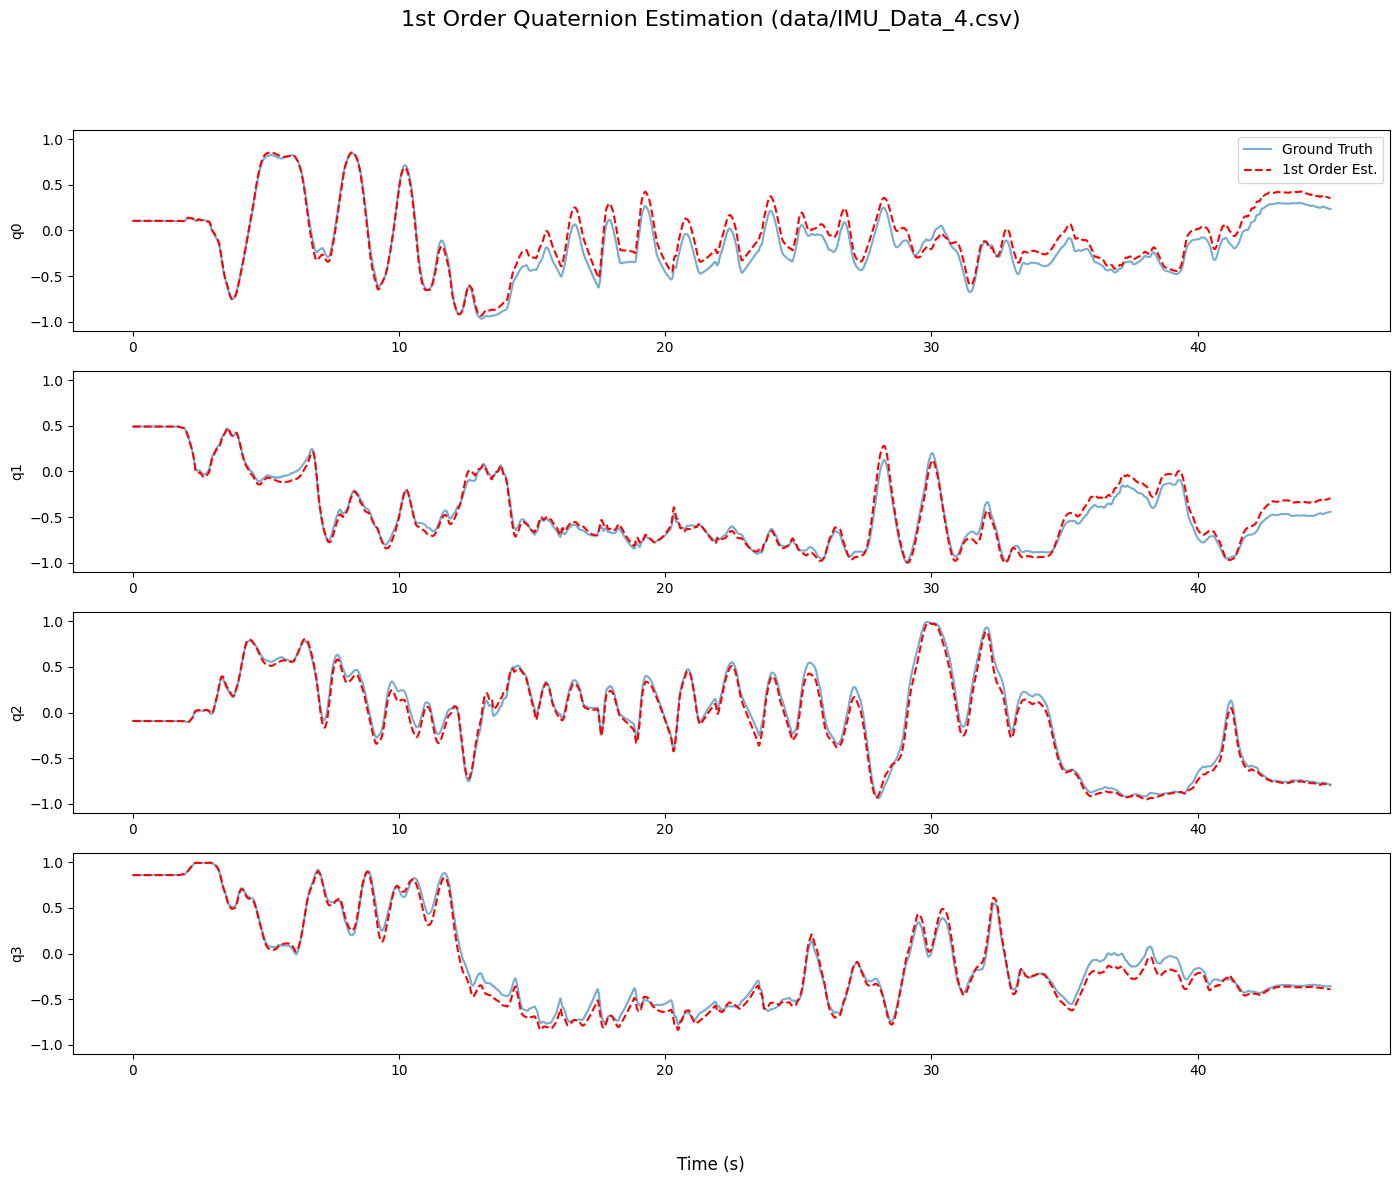

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

filename = 'data/IMU_Data_4.csv'

f = 100 #Hz
dt = 1/f

df = pd.read_csv(filename)
df[['Gyro_x', 'Gyro_y', 'Gyro_z']] *= np.pi / 180

time = np.arange(len(df)) / f
view_window = slice(0, 4500)

q_truth_arr = df[['Quat_0', 'Quat_1', 'Quat_2', 'Quat_3']].to_numpy()
omega_arr = df[['Gyro_x', 'Gyro_y', 'Gyro_z']].to_numpy()

q_prev = q_truth_arr[0]
q_est_1st_arr = [q_prev]

for w_x, w_y, w_z in omega_arr[1:]:
    Omega_w = np.array([
        [0, -w_x, -w_y, -w_z],
        [w_x, 0, w_z, -w_y],
        [w_y, -w_z, 0, w_x],
        [w_z, w_y, -w_x, 0]
    ])
    
    q_dot =  0.5  * Omega_w @ q_prev
    q = q_prev + q_dot * dt
    q = q / np.linalg.norm(q)
    
    q_est_1st_arr.append(q)
    q_prev = q

truth_components = q_truth_arr.view(np.float64).reshape(-1, 4)
est_1st = np.array(q_est_1st_arr).view(np.float64).reshape(-1, 4)

fig, ax = plt.subplots(4, 1, figsize=(17,12))

for i in range(4):
    ax[i].plot(time[view_window], truth_components[view_window, i], label='Ground Truth', alpha=0.6)
    ax[i].plot(time[view_window], est_1st[view_window, i], label='1st Order Est.', linestyle='dashed', color='red')
    ax[i].set_ylabel(f'q{i}')
    ax[i].set_ylim([-1.1, 1.1])
    
ax[0].legend(loc='upper right') 
fig.suptitle(f'1st Order Quaternion Estimation ({filename})', fontsize=16)
fig.supxlabel('Time (s)');

# Scheme 2: Madgwick Filter

- We should avoid this, because Madgwick assumes linear accelerations are short-lived. Our rocket is under sustained thrust, so we should avoid Madgwick for later phases. Perhaps we can do Kalman filtering.
- Performs better than simple first-order approx.
- This is for demonstration purposes.

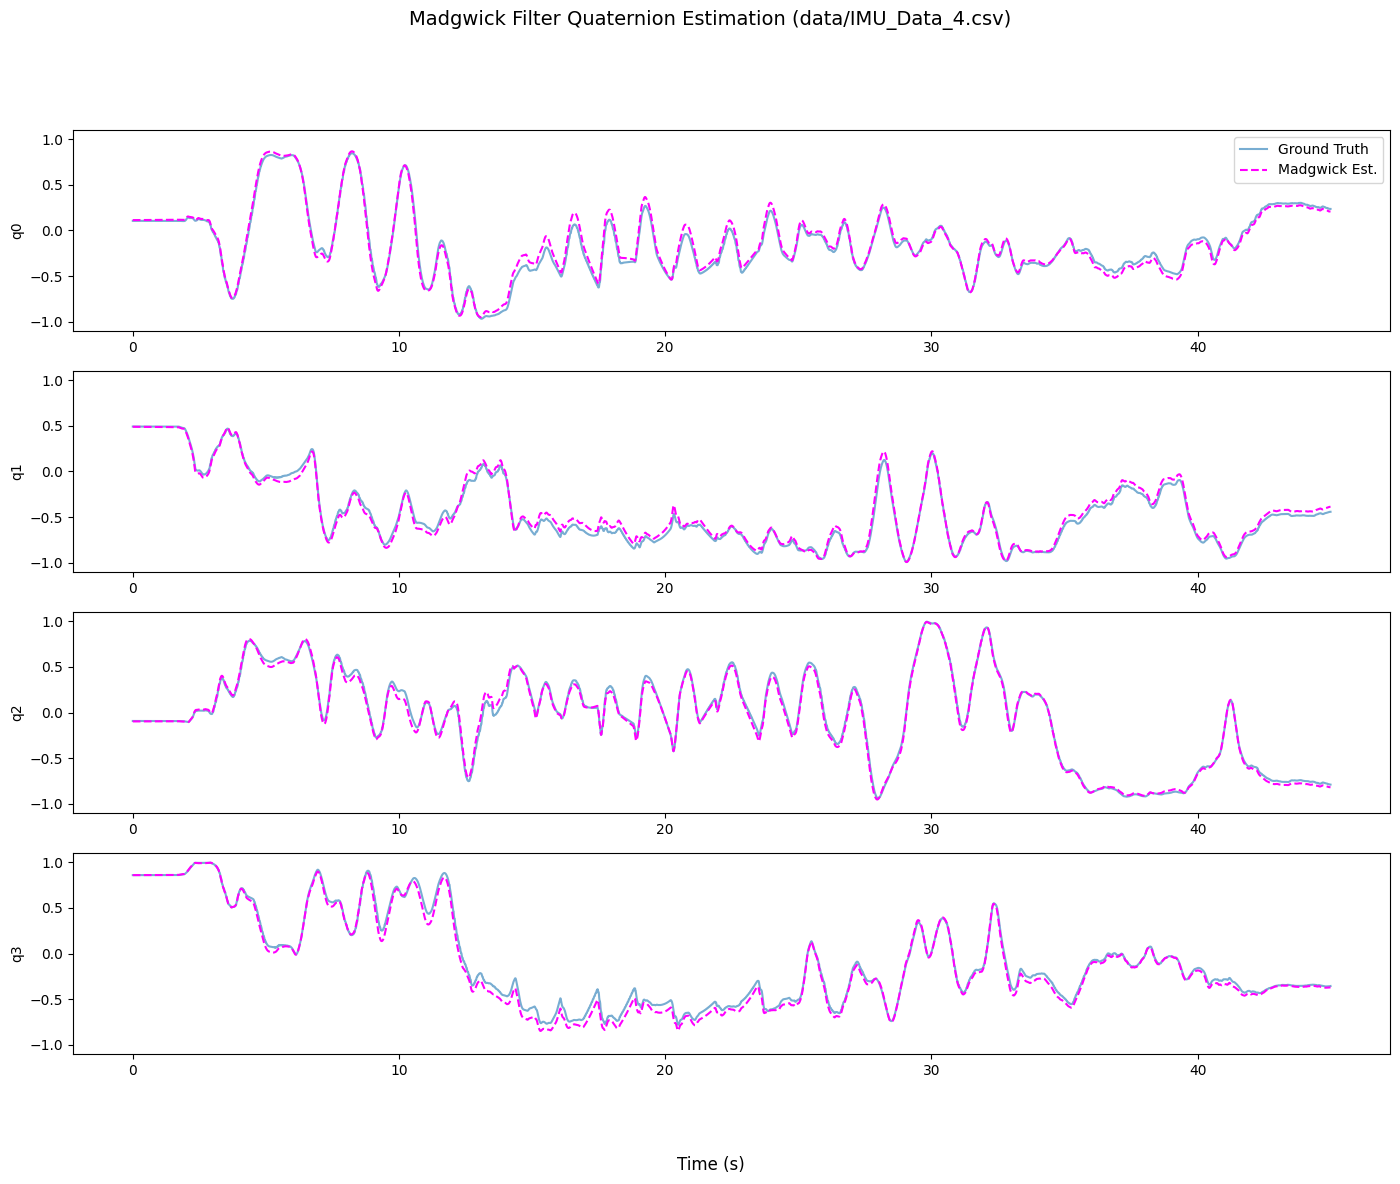

In [44]:
from ahrs.filters import Madgwick
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

filename = 'data/IMU_Data_4.csv'

f = 100 #Hz
dt = 1/f

df = pd.read_csv(filename)

time = np.arange(len(df)) / f
view_window = slice(0, 4500)

omega = df[['Gyro_x', 'Gyro_y', 'Gyro_z']].to_numpy() * np.pi / 180
acc = df[['Acc_x', 'Acc_y', 'Acc_z']].to_numpy()
mag = df[['Mag_x', 'Mag_y', 'Mag_z']].to_numpy()

madgwick = Madgwick(gyr=omega, acc=acc, mag=mag, frequency=f, beta=0.0075)

q_est_madgwick = madgwick.Q # Madgwick returns conjugate quaternions

fig, ax = plt.subplots(4, 1, figsize=(17,12))

truth = q_truth_arr.view(np.float64).reshape(-1, 4)
est_madg = q_est_madgwick.view(np.float64).reshape(-1, 4)

for i in range(4):
    ax[i].plot(time[view_window], truth[view_window, i], label='Ground Truth', alpha=0.6)
    # ax[i].plot(time[view_window], est_1st[view_window, i], label='1st Order Est.', linestyle='dashed', color='red')
    ax[i].plot(time[view_window], est_madg[view_window, i], label='Madgwick Est.', linestyle='dashed', color='magenta')
    ax[i].set_ylabel(f'q{i}')
    ax[i].set_ylim([-1.1, 1.1])

ax[0].legend(loc='upper right') 
fig.suptitle(f'Madgwick Filter Quaternion Estimation ({filename})', fontsize=14)
fig.supxlabel('Time (s)');

## Computing the Euler Angles

- We will use the common ZYX convention for Euler angles. 

: 